In [6]:
import scipy as sp
import scipy.signal
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import re
import xml.etree.ElementTree as ET
import os
#import pandas as pd
#import sympy as smp
import plotly.graph_objects as go
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D


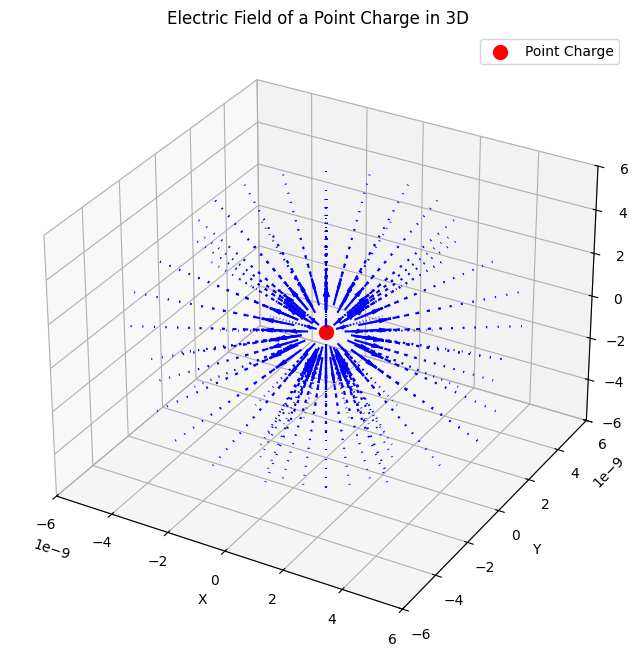

In [7]:


# Constants
k_e = 8.99e9  # Coulomb's constant in N·m^2/C^2
Q = 1e-9      # Point charge in Coulombs (1nC)

theta, phi = np.linspace(0, 2*np.pi, 10), np.linspace(0, np.pi, 10)
r = np.linspace(1, 6, 15)

THETA, PHI, R = np.meshgrid(theta, phi, r*10**(-9))

Xr = np.sin(THETA)*np.cos(PHI)
Yr = np.sin(THETA) * np.sin(PHI)
Zr = np.cos(THETA)

Xtheta = np.cos(THETA)*np.cos(PHI)
Ytheta = np.cos(THETA) * np.sin(PHI)
Ztheta = -np.sin(THETA)

Xphi = -np.sin(PHI)
Yphi = np.cos (PHI)
Zphi = 0

Ex = Xr*k_e * Q/(R**2)
Ey = Yr*k_e * Q/(R**2)
Ez = Zr*k_e * Q/(R**2)


X = R* np.sin(THETA)*np.cos(PHI)
Y = R* np.sin(THETA) * np.sin(PHI)
Z = R* np.cos(THETA)

#Xtheta = 


u = Ex#* (X/R)
v = Ey#* (Y/R)
w = Ez#* (Z/R)


# Set up the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the vector field using quiver3D
ax.quiver(X, Y, Z, Ex, Ey, Ez, length=1*10**(-28), normalize=False, color='b')

# Add the point charge at the origin
ax.scatter(0, 0, 0, color='r', s=100, label='Point Charge')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Electric Field of a Point Charge in 3D')

# Set limits
ax.set_xlim([-6*10**(-9), 6*10**(-9)])
ax.set_ylim([-6*10**(-9), 6*10**(-9)])
ax.set_zlim([-6*10**(-9), 6*10**(-9)])

# Show the plot
plt.legend()
plt.show()



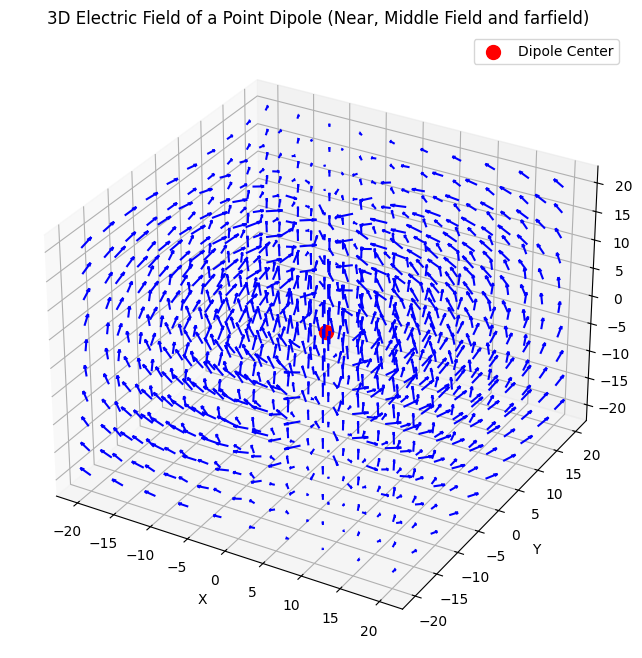

In [8]:


# Define the dipole moment (along the z-axis)
p = np.array([0, 0, 0.1])

# Create a 3D grid
x = np.linspace(-20, 20, 10)
y = np.linspace(-20, 20, 10)
z = np.linspace(-20, 20, 10)
X, Y, Z = np.meshgrid(x, y, z)

# Initialize electric field components
Ex, Ey, Ez = np.zeros(X.shape), np.zeros(Y.shape), np.zeros(Z.shape)

# Compute electric field at each grid point
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            r = np.array([X[i, j, k], Y[i, j, k], Z[i, j, k]])
            r_mag = np.linalg.norm(r)

            if r_mag == 0:  # Avoid singularity at the dipole location
                continue
            
            r_hat = r / r_mag
            
             # Compute near-field (1/r^3 term)
            E_near = (1 / r_mag**3) * (3 * np.dot(p, r_hat) * r_hat - p)

            # Compute middle-field (1/r^2 term)
            E_middle = -(1 / r_mag**2) * (np.dot(np.dot(r_hat, p), r_hat))  # Fixed sign error

            # Compute far-field (1/r term, radiative term)
            E_far = (1 / r_mag) * np.cross(np.cross(r_hat, p), r_hat)  # Added far-field term

            # Total electric field (Near-field + Middle-field + Far-field)
            E = E_near + E_middle + E_far

            
            # Total electric field (Near-field + Middle-field)
            E = E_near + E_middle + E_far
            
            Ex[i, j, k], Ey[i, j, k], Ez[i, j, k] = E

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the vector field
ax.quiver(X, Y, Z, Ex, Ey, Ez, length=2, normalize=True, color='b')

# Mark the dipole position
ax.scatter([0], [0], [0], color='r', s=100, label="Dipole Center")

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Electric Field of a Point Dipole (Near, Middle Field and farfield)")
ax.legend()
plt.show()

# Expand to N dipoles at distance d and phase phi

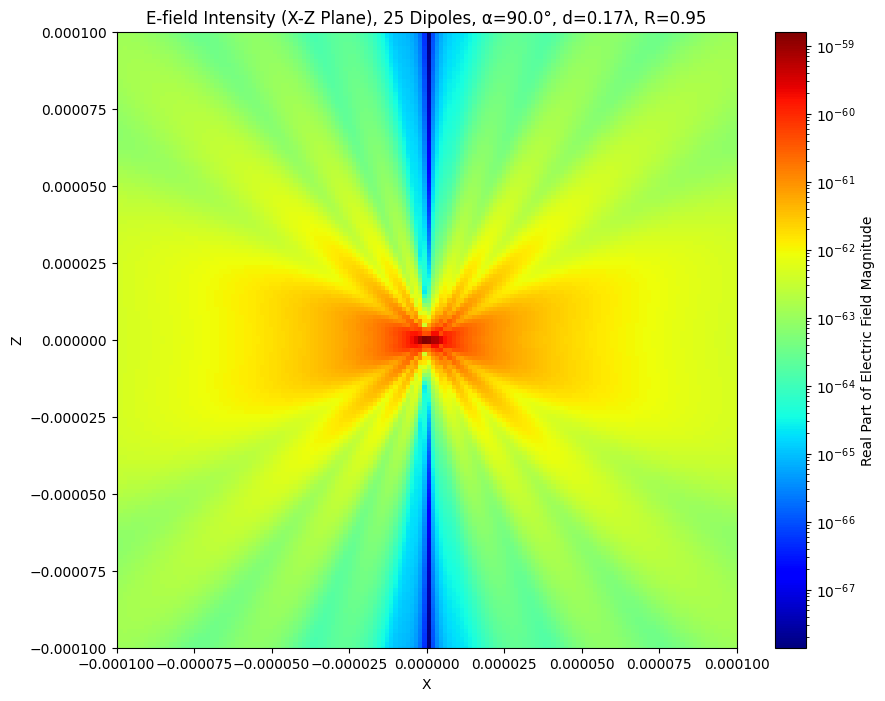

In [20]:
#use numba

import numba

# Define parameters
alpha = np.deg2rad(90) 
p_val = 10 * 10e-30  # C*m
p = np.array([p_val * np.cos(alpha), 0, p_val * np.sin(alpha)])

size = 100000
nano = 1e-9
lambda_0 = 600 * nano  # Example wavelength
k = 2 * np.pi / lambda_0  # Wave number
N = 25 
c = 2.998e8
omega = k * c

dipole_distance = 100 * nano  
indices = np.arange(0, N, 1) 
positions = np.array([[idx * dipole_distance, 0, 0] for idx in indices])  # NumPy array for fast access
phases = np.array([np.absolute(idx) * np.pi for idx in indices], dtype=np.complex128)  # Complex dtype for fast operations
6
# Create 2D grids
x = np.linspace(-size * nano, size * nano, 150)
y = np.linspace(-size * nano, size * nano, 150)
z = np.linspace(-size * nano, size * nano, 150)

X, Z = np.meshgrid(x, z)
X_Y, Y = np.meshgrid(x, y)
Y_Z, Z_Y = np.meshgrid(y, z)


@numba.njit(parallel=True, fastmath=True)
def compute_field(coord1, coord2, coord3, component, positions, indices, phases, p, k, R):
    grid_shape = coord1.shape
    field = np.zeros(grid_shape, dtype=np.complex128)
    
    for i in numba.prange(grid_shape[0]):  # Parallel loop
        for j in range(grid_shape[1]):
            E_total = np.array([0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j], dtype=np.complex128)

            for dip_idx in range(len(indices)):
                r = np.array([coord1[i, j], coord2[i, j], coord3[i, j]]) - positions[dip_idx]
                r_mag = np.sqrt(np.sum(r ** 2)) + 1e-12  # Avoid division by zero
                r_hat = r / r_mag
                
                rho = k * r_mag  # Phase argument

                # Compute field components
                dot_pr = np.dot(r_hat, p)
                
                E_near = (1 / rho**3) * (3 * dot_pr * r_hat - p)
                E_middle = - (1j / rho**2) * (dot_pr * r_hat - p)
                E_far = (1 / rho) * np.cross(np.cross(r_hat, p), r_hat)

                # Apply phase factor and damping
                phase_factor = np.exp(1j * (rho + phases[dip_idx]))

                E_total +=  (E_near + E_middle + E_far) * phase_factor

            field[i, j] = E_total[component]

    return field


# Compute field components with Numba-accelerated function
Ex = compute_field(X, np.zeros_like(X), Z, 0, positions, indices, phases, p, k, R)
Ez = compute_field(X, np.zeros_like(X), Z, 2, positions, indices, phases, p, k, R)
Ey = compute_field(X_Y, Y, np.zeros_like(X_Y), 1, positions, indices, phases, p, k, R)

# Compute intensity
E_intensity = np.real(Ex * np.conjugate(Ex) + Ey * np.conjugate(Ey) + Ez * np.conjugate(Ez))

# Plot results
fig, ax = plt.subplots(figsize=(10, 8))
norm = mcolors.LogNorm(vmin=E_intensity.min(), vmax=E_intensity.max())
cmap = ax.pcolormesh(X, Z, E_intensity, cmap='jet', shading='auto', norm=norm)
plt.colorbar(cmap, ax=ax, label='Real Part of Electric Field Magnitude')

# Labels and title
ax.set_xlim(-size * nano, size * nano)
ax.set_ylim(-size * nano, size * nano)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_title(f"E-field Intensity (X-Z Plane), {N} Dipoles, α={np.rad2deg(alpha)}°, d={dipole_distance/lambda_0:.2f}λ, R={R}")

# Save and show plot
#plt.savefig(f"E_field_Intensity_XZ_{N}_Dipoles_{int(np.rad2deg(alpha))}_alpha_{dipole_distance/lambda_0:.2f}lambda_{size}nm_R_{R}.png")
plt.show()


In [13]:
phases

array([37.69911184+0.j, 34.55751919+0.j, 31.41592654+0.j, 28.27433388+0.j,
       25.13274123+0.j, 21.99114858+0.j, 18.84955592+0.j, 15.70796327+0.j,
       12.56637061+0.j,  9.42477796+0.j,  6.28318531+0.j,  3.14159265+0.j,
        0.        +0.j,  3.14159265+0.j,  6.28318531+0.j,  9.42477796+0.j,
       12.56637061+0.j, 15.70796327+0.j, 18.84955592+0.j, 21.99114858+0.j,
       25.13274123+0.j, 28.27433388+0.j, 31.41592654+0.j, 34.55751919+0.j,
       37.69911184+0.j])

## scan phi

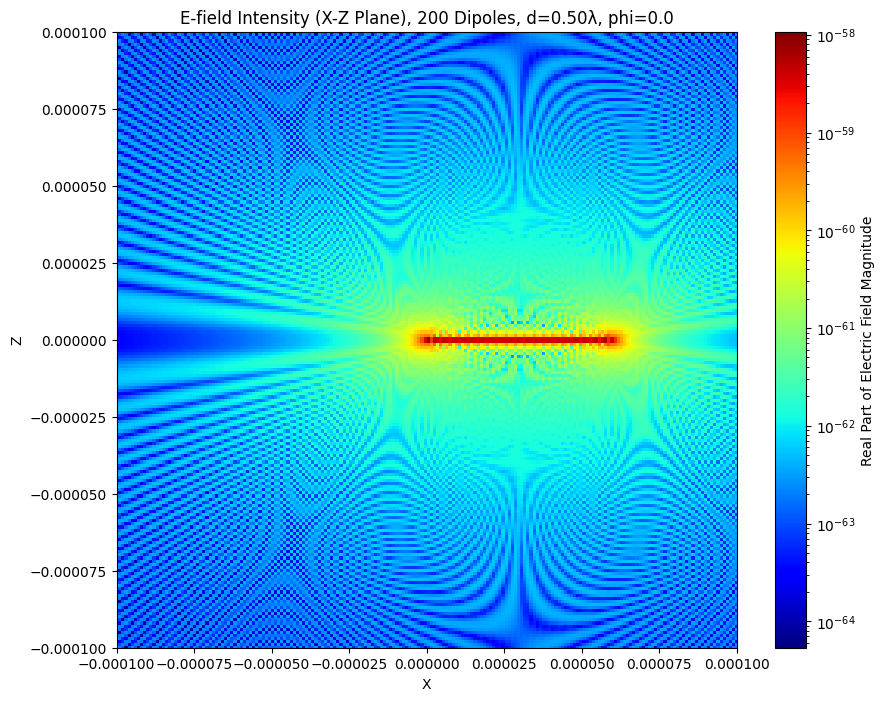

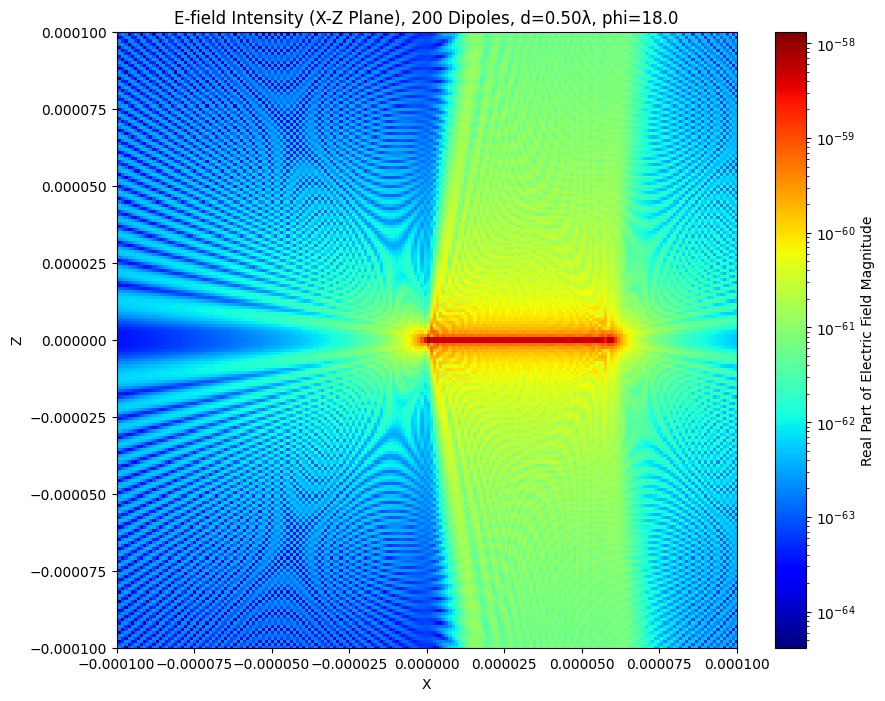

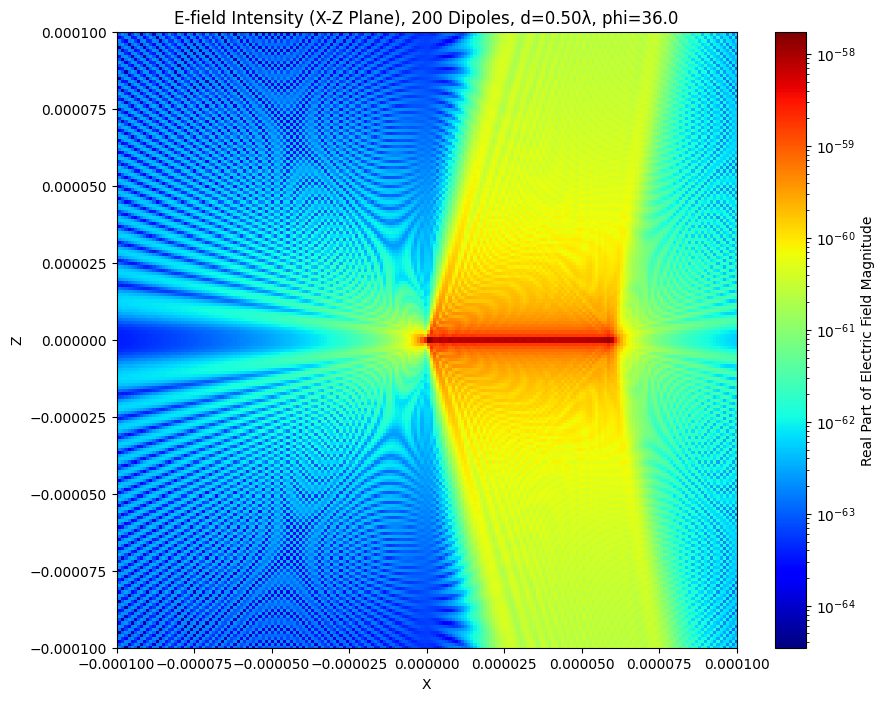

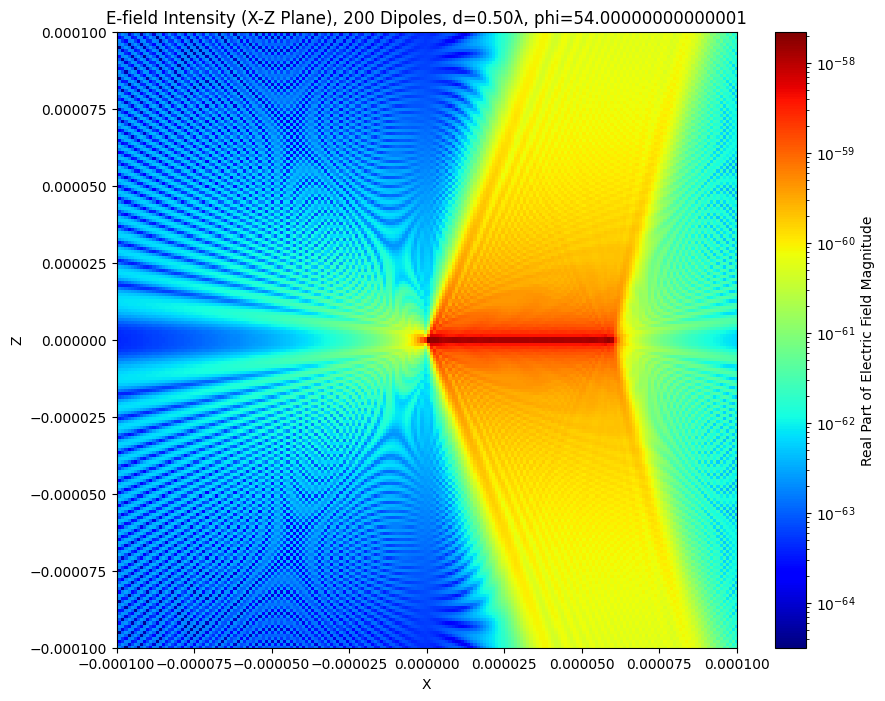

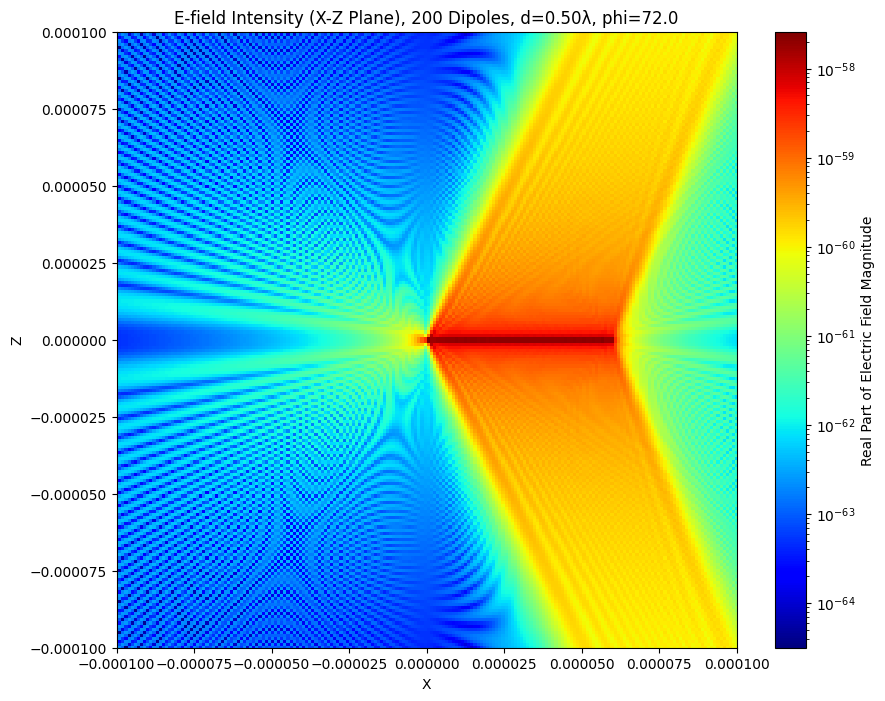

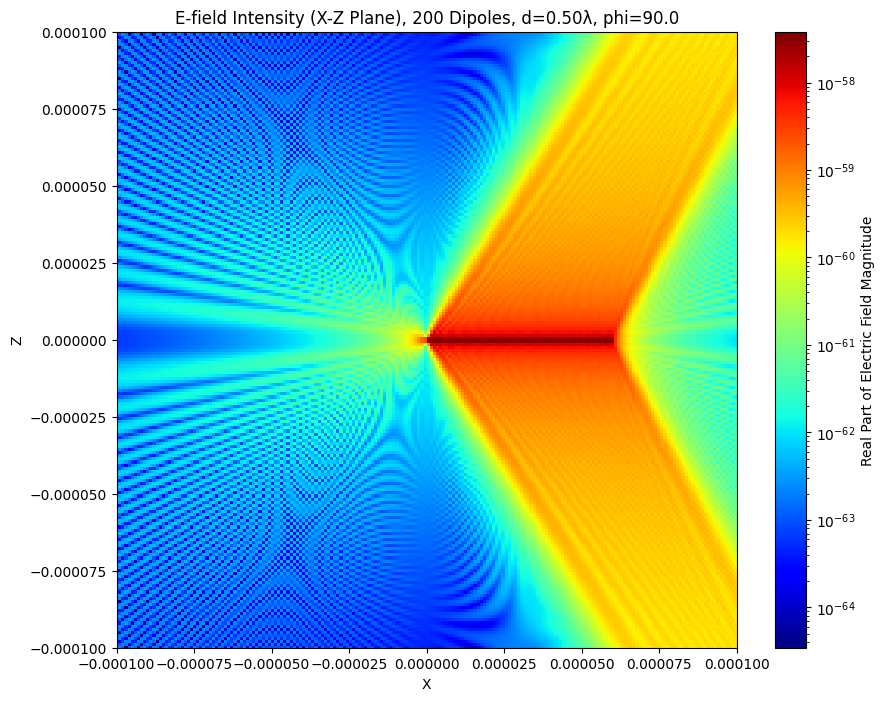

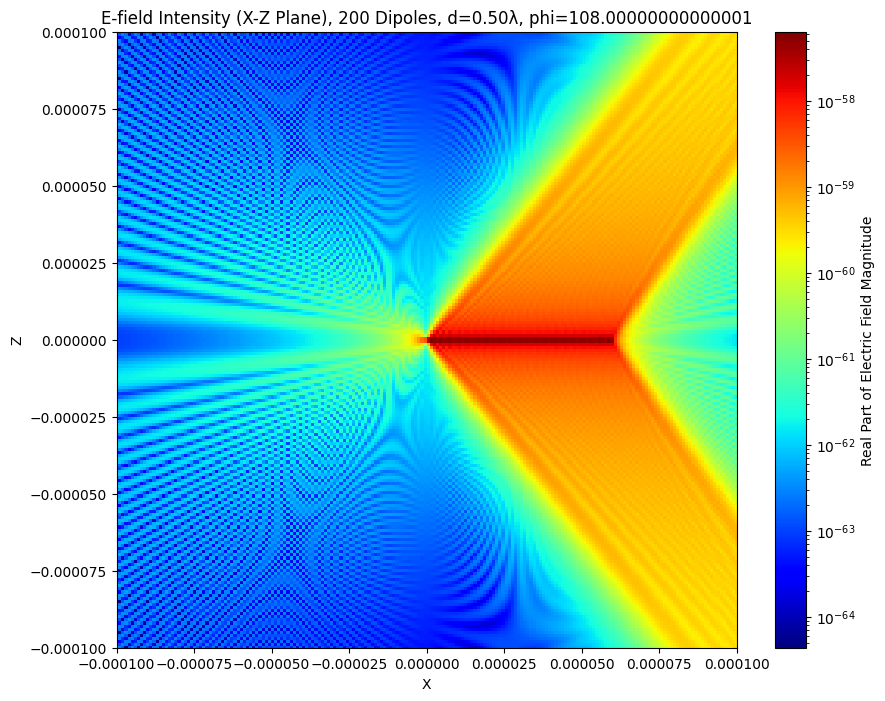

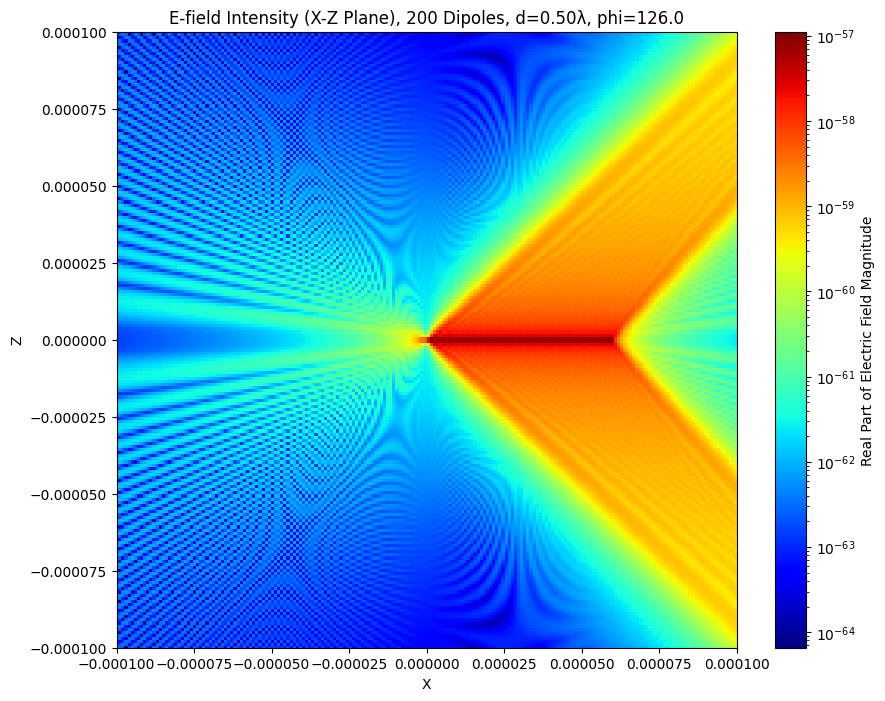

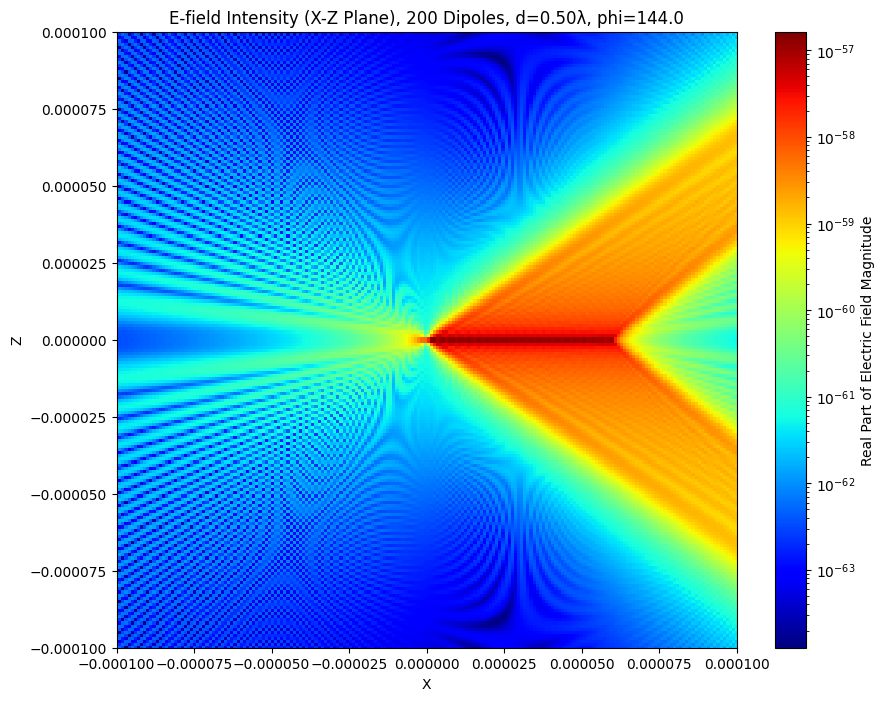

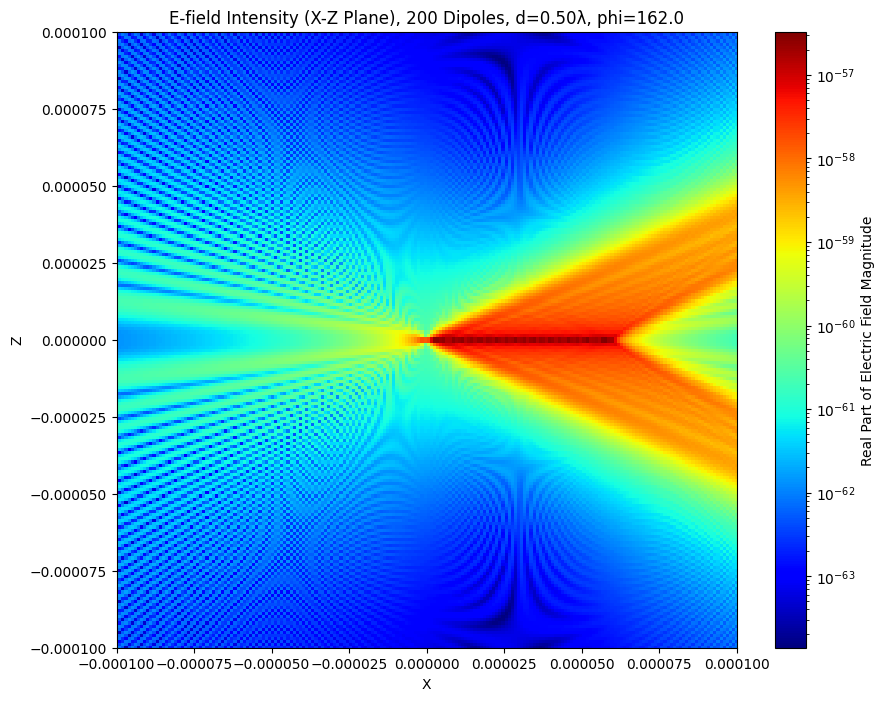

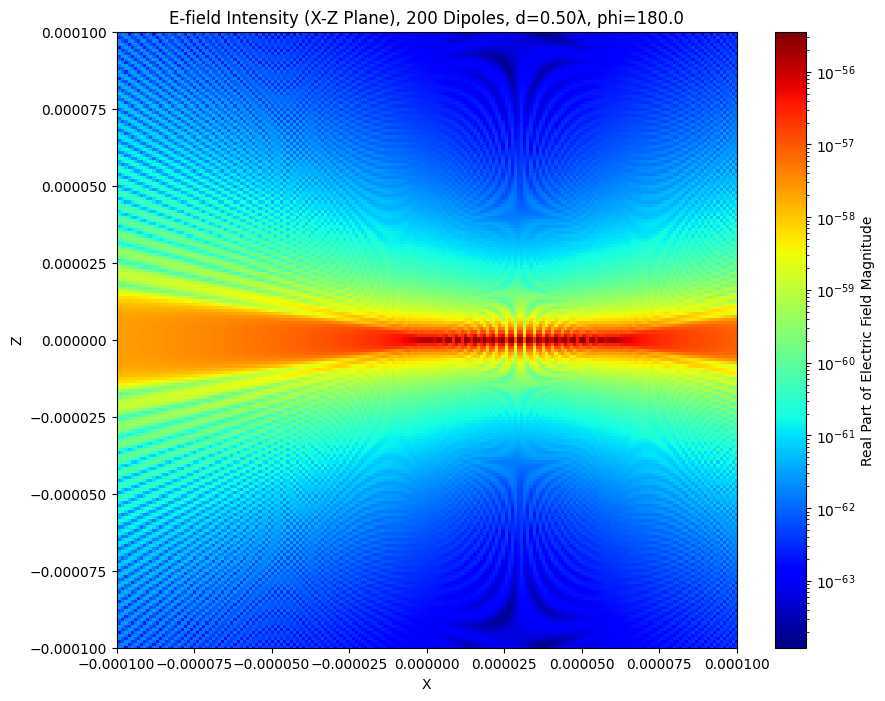

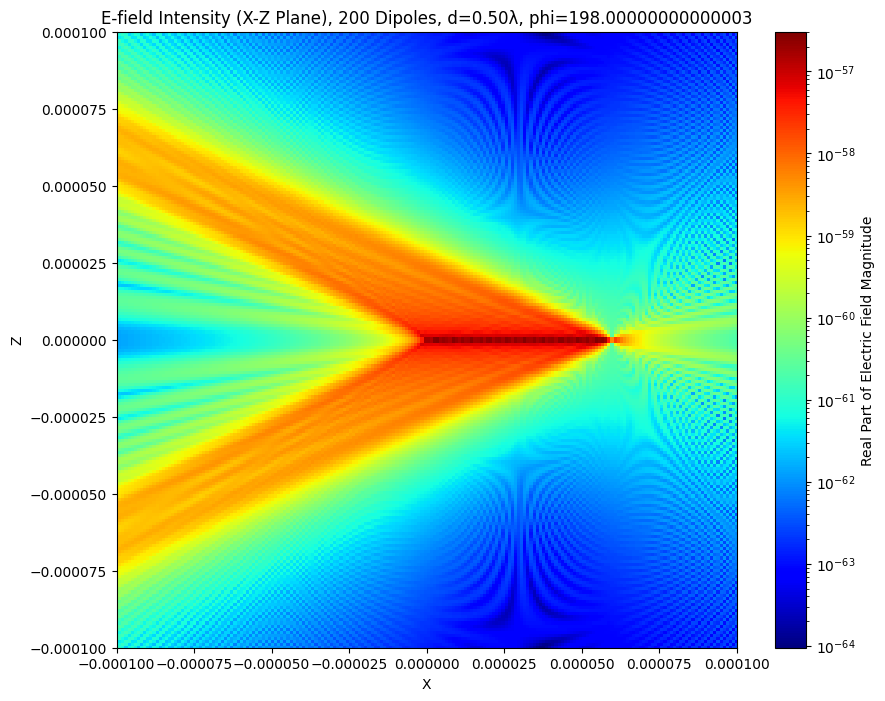

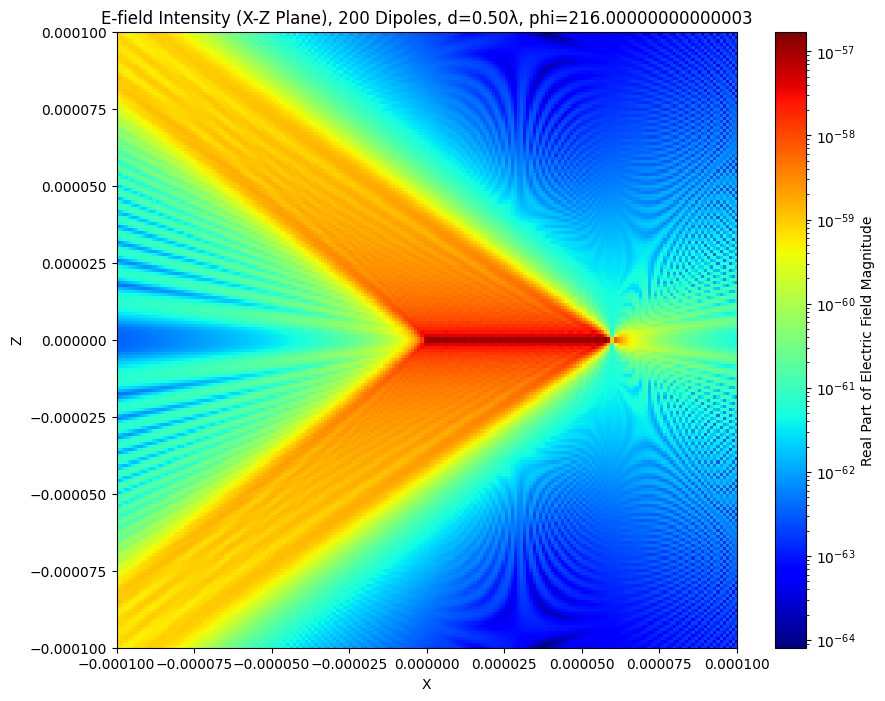

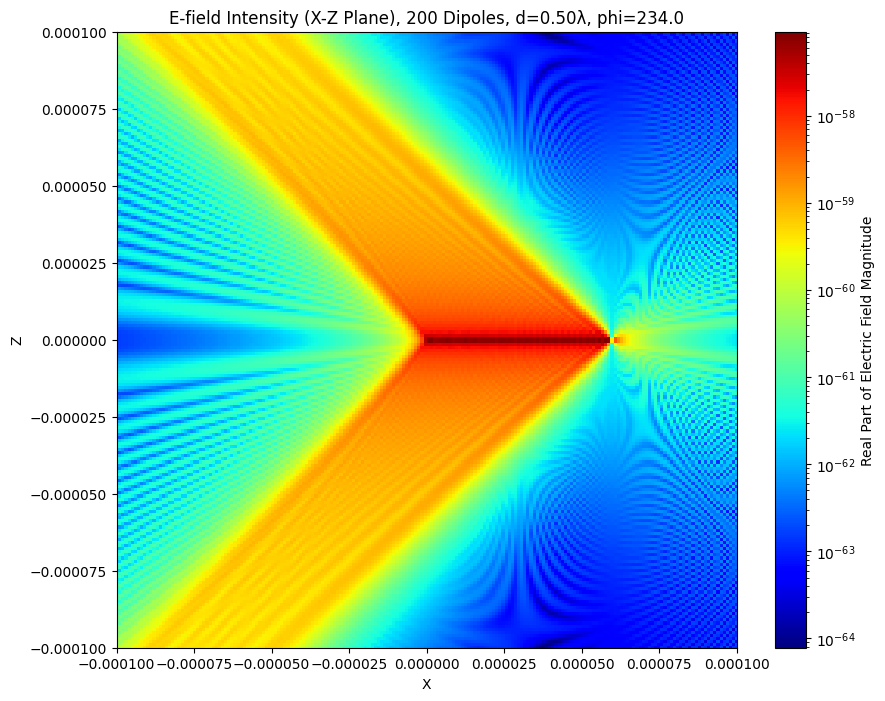

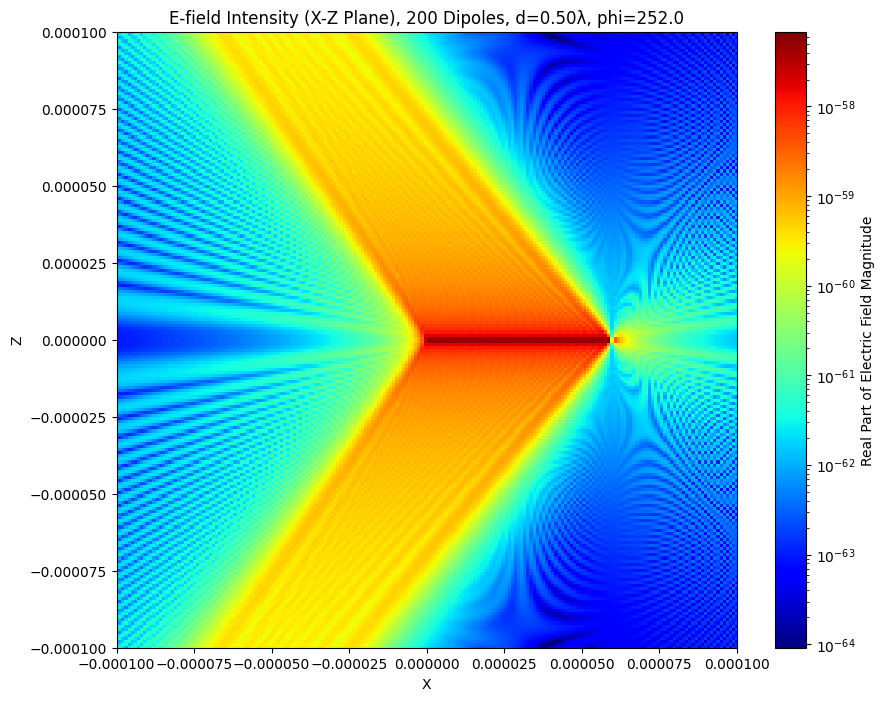

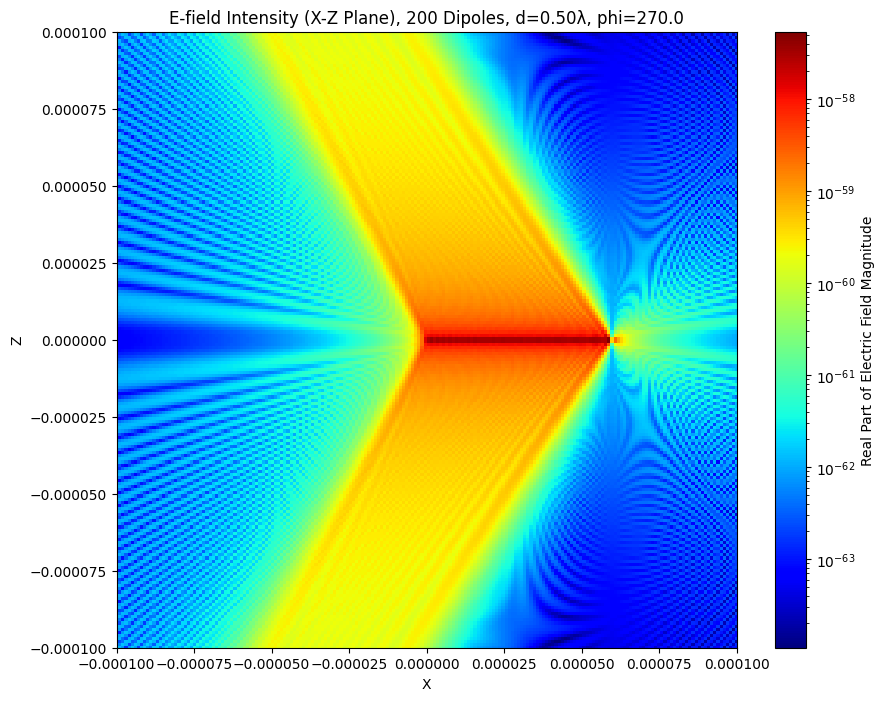

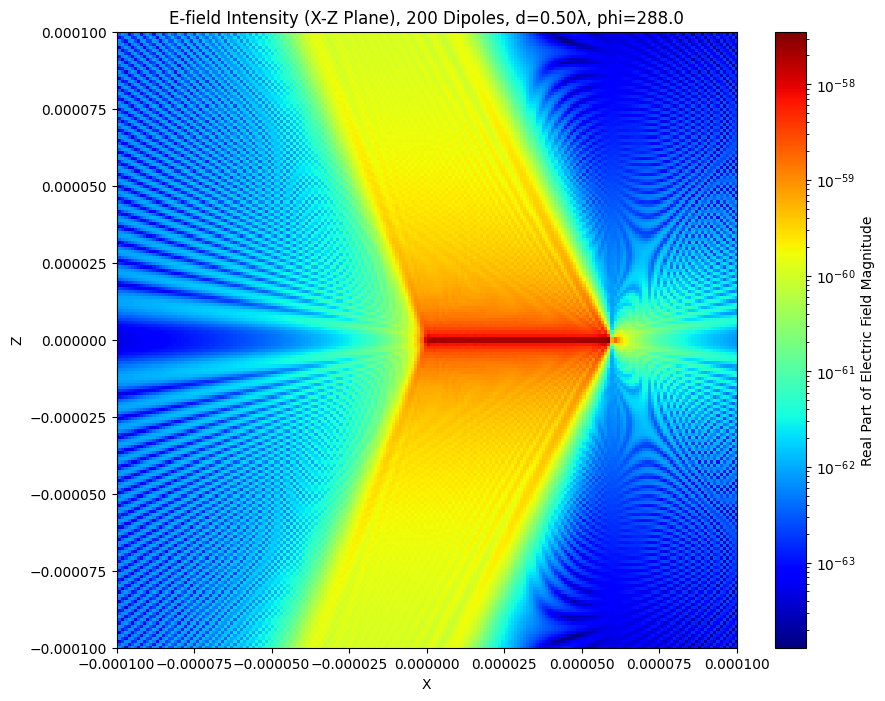

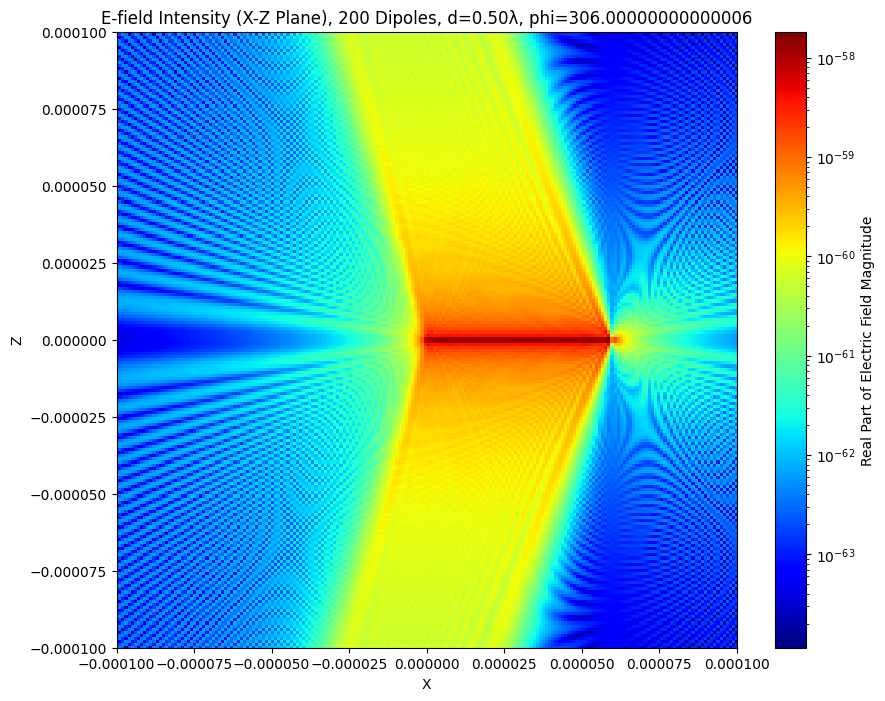

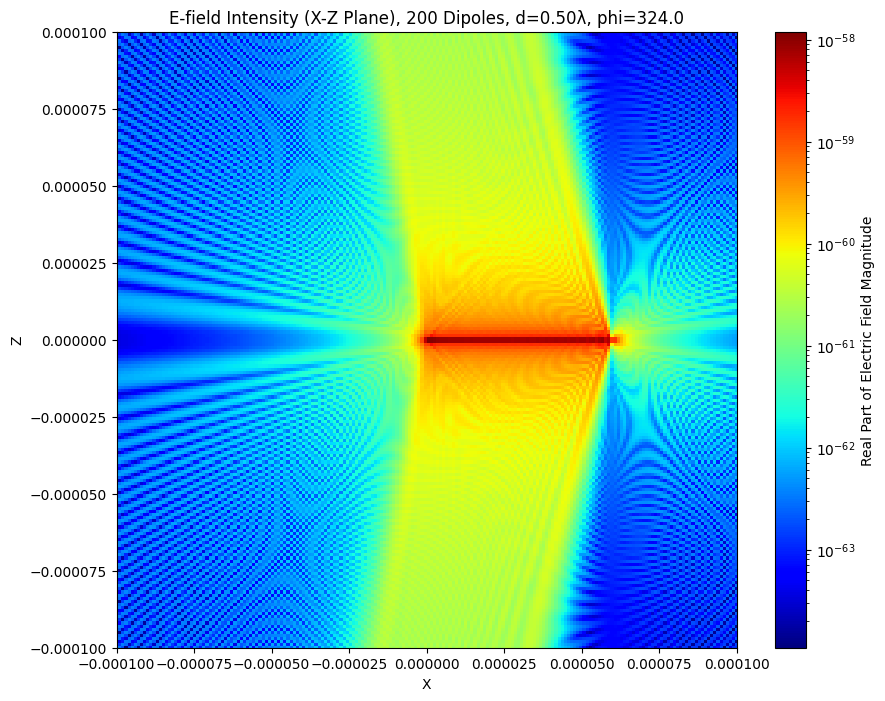

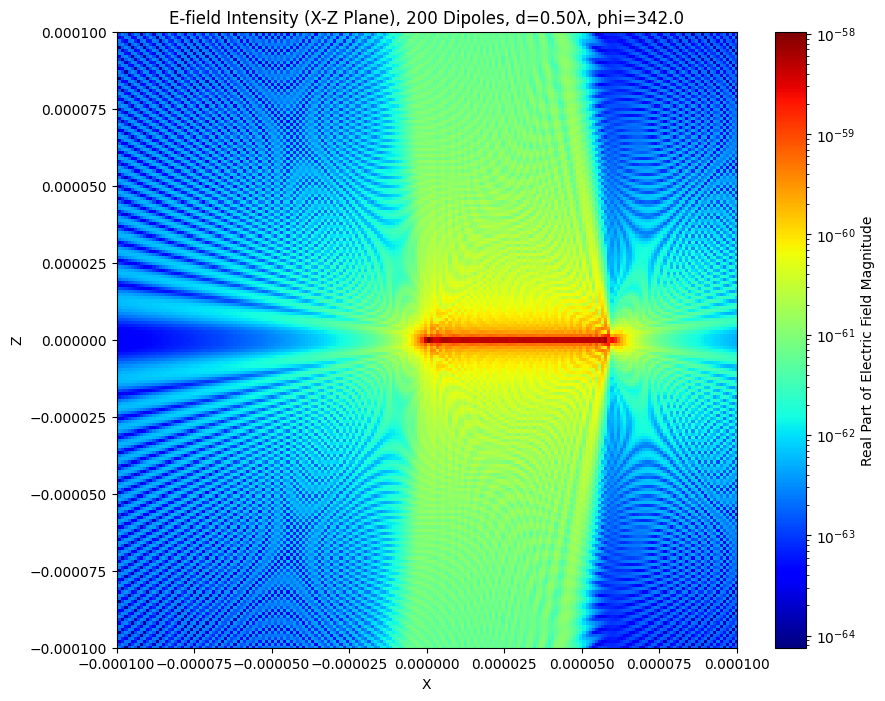

In [27]:
#use numba

import numba

# Define parameters
alpha = np.deg2rad(90) 
p_val = 10 * 10e-30  # C*m
p = np.array([p_val * np.cos(alpha), 0, p_val * np.sin(alpha)])

size = 100000
nano = 1e-9
lambda_0 = 600 * nano  # Example wavelength
k = 2 * np.pi / lambda_0  # Wave number
N = 200  # Number of dipoles 
c = 2.998e8
omega = k * c

dipole_distance = 300 * nano  #can be varried (also interesting ;) )
indices = np.arange(0, N, 1) 
positions = np.array([[idx * dipole_distance, 0, 0] for idx in indices])  # NumPy array for fast access

# Create 2D grids
x = np.linspace(-size * nano, size * nano, 200)
y = np.linspace(-size * nano, size * nano, 200)
z = np.linspace(-size * nano, size * nano, 200)

X, Z = np.meshgrid(x, z)
X_Y, Y = np.meshgrid(x, y)
Y_Z, Z_Y = np.meshgrid(y, z)


@numba.njit(parallel=True, fastmath=True) # function not yet fully numba optimized
def compute_field(coord1, coord2, coord3, component, positions, indices, phases, p, k, R):
    grid_shape = coord1.shape
    field = np.zeros(grid_shape, dtype=np.complex128)
    
    for i in numba.prange(grid_shape[0]):  # Parallel loop
        for j in range(grid_shape[1]):
            E_total = np.array([0.0 + 0.0j, 0.0 + 0.0j, 0.0 + 0.0j], dtype=np.complex128)

            for dip_idx in range(len(indices)):
                r = np.array([coord1[i, j], coord2[i, j], coord3[i, j]]) - positions[dip_idx]
                r_mag = np.sqrt(np.sum(r ** 2)) + 1e-12  # Avoid division by zero
                r_hat = r / r_mag
                
                rho = k * r_mag  # Phase argument

                # Compute field components
                dot_pr = np.dot(r_hat, p)
                
                E_near = (1 / rho**3) * (3 * dot_pr * r_hat - p) #not needed for far field evaluation
                E_middle = - (1j / rho**2) * (dot_pr * r_hat - p) #not needed for far field evaluation
                E_far = (1 / rho) * np.cross(np.cross(r_hat, p), r_hat)

                # Apply phase factor 
                phase_factor = np.exp(1j * (rho + phases[dip_idx]))

                E_total += (E_near + E_middle + E_far) * phase_factor

            field[i, j] = E_total[component]

    return field

phase_step = np.arange(0,2,0.1) #adjust for stepsize and min, max phase (here it goes from 0 pi to 2 pi in 0.1 pii steps
    
for n in phase_step:
    phases = np.array([np.absolute(idx) * n* np.pi for idx in indices], dtype=np.complex128)  # Complex dtype for fast operations
    # Compute field components with Numba-accelerated function
    Ex = compute_field(X, np.zeros_like(X), Z, 0, positions, indices, phases, p, k, R)
    Ez = compute_field(X, np.zeros_like(X), Z, 2, positions, indices, phases, p, k, R)
    Ey = compute_field(X_Y, Y, np.zeros_like(X_Y), 1, positions, indices, phases, p, k, R)
    
    # Compute intensity
    E_intensity = np.real(Ex * np.conjugate(Ex) + Ey * np.conjugate(Ey) + Ez * np.conjugate(Ez))
    
    # Plot results
    fig, ax = plt.subplots(figsize=(10, 8))
    norm = mcolors.LogNorm(vmin=E_intensity.min(), vmax=E_intensity.max())
    cmap = ax.pcolormesh(X, Z, E_intensity, cmap='jet', shading='auto', norm=norm)
    plt.colorbar(cmap, ax=ax, label='Real Part of Electric Field Magnitude')
    
    # Labels and title
    ax.set_xlim(-size * nano, size * nano)
    ax.set_ylim(-size * nano, size * nano)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_title(f"E-field Intensity (X-Z Plane), {N} Dipoles, d={dipole_distance/lambda_0:.2f}λ, phi={np.rad2deg(n* np.pi)}")
    
    # Save and show plot
    #plt.savefig(f"E-field Intensity (X-Z Plane), {N} Dipoles, d={dipole_distance/lambda_0:.2f}λ, phi={np.rad2deg(n* np.pi)}")
    plt.show()
